Experiment 1: 

- 4 different constructs
One sequencing run with barcoding

- 10 different amino acids
Each amino acid gets one sequencing run

In [1]:
#@title IMPORTS
from random import *
import numpy as np
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter 
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from collections import OrderedDict
import matplotlib.pyplot as plt
#!pip install ipython-autotime

Make a demo data set to test code

Parameters: stem/constant region, length of randomized region, location of the coordinating triplet, triplet preference, triplet advantage, number of sequences

In [2]:
###CREATE DEMO DATA TO TEST CODE
#4 Constructs
#10 Amino Acids Each

#STEM1234568910METS

stem = 'AAAA'
randomized_len = 10
triplet_start = 1
number_of_seqs = 1000
selection_advantage_single_nt = 0.1
background_selection = 0.1
preference = 'AUG'

#Create Pool
random_pool = []
for j in range(number_of_seqs):
    randomized_seq = stem
    for i in range(randomized_len):
        new_nt = np.random.choice(['C', 'G', 'A', 'U'])
        randomized_seq+=new_nt
    randomized_seq+='UUUU'
    random_pool.append(randomized_seq)

#Add preference via 1 round of selection
#Add stochasticity 
selected_pool = []

for seq in random_pool:
    selection_probability = background_selection
    for position in range(3):
        if seq[len(stem)+triplet_start-1+position] == preference[position]:
            selection_probability+=selection_advantage_single_nt

    if selection_probability>np.random.random():
        selected_pool.append(seq)

print('Starting Pool Length: '+str(number_of_seqs))
print('Selected Pool Length: '+str(len(selected_pool)))
print('Selected Pool Unique Sequences: '+str(len(list(set(selected_pool)))))

Starting Pool Length: 1000
Selected Pool Length: 160
Selected Pool Unique Sequences: 160


Parameters for real data set - reverse complement, trimmed region, quality cutoff, and clusters

In [3]:
#Instructions:
#1) Name the raw .fastq file: 'Aleks.fastq', UNZIPPED
#2) Input the following parameters - defaults are already set
#3) On the bar at the top, press 'Runtime' and then 'Restart and Run All'

#Take the reverse complement? Enter 'yes' or 'no'
rc = 'no'

#Desired Region to analyze (e.g. if 8nt constant region in 56nt sequence, input 'start, stop = 8, 48')
start, stop = 13, 23

#Quality Cutoff - what fraction of positions should have <1% error probability?
quality_cutoff = 0.9

#Number of Clusters (I WOULD MAKE THIS >50)
k = 50

ANALYSIS #1: Statistics for each run

In [4]:
#@title STATISTICS (note: this takes a few mins per round)

round = open('/Users/zoeweiss/Desktop/Desktop/fastq/smaller_ai/Aleks4.fastq').readlines()
quality = round[3::4]
seqs = round[1::4]
print('Number of raw seqs: '+str(len(seqs))) 

#Remove duplicates:
unique_seqs = []
unique_qualities = []
indicies_of_unique_seqs = list(np.unique(seqs, return_index=True)[1])
for index in sorted(np.unique(seqs, return_index = True)[1])[:-1]:
  unique_qualities.append(quality[index])
  unique_seqs.append(seqs[index])
print('Number of unique seqs: '+str(len(unique_seqs))) 

#Counts of all seqs
seq_dict = Counter(seqs)
seq_dict_list = [(k, v) for k, v in seq_dict.items()]
sorted_seq_dict = sorted(seq_dict_list, key = lambda x: x[1], reverse=True)
sorted_seq_dict_inve = sorted(seq_dict_list, key = lambda x: x[1])

#Take RC if desired
pre_trim = []
if rc == 'yes':
  rc_seqs = []
  for sequence in unique_seqs:
      rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n'))
  pre_trim = rc_seqs
else:
  for sequence in unique_seqs:
      pre_trim.append(str(Seq(sequence)).strip('\n'))
if rc == 'yes':
  print('Number of seqs after rc: '+str(len(pre_trim))) 

#Trim
trimmed = []
for seq in pre_trim:
  trimmed.append(seq[(start-1):(stop-1)])
print('Number of seqs after trimming: '+str(len(trimmed))) 

#Filter by quality
high_quality = []
acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
for seq in range(len(unique_qualities)):
  overlap=0
  for char in list(set(unique_qualities[seq]).intersection(acceptable_quals_1_percent_error)):
        overlap+=unique_qualities[seq].count(char)
  if overlap/len(unique_qualities[1])>quality_cutoff:
        high_quality.append(trimmed[seq].strip("\n"))
print('Number of high quality seqs: '+str(len(high_quality))) 

Number of raw seqs: 2519
Number of unique seqs: 1615
Number of seqs after trimming: 1615
Number of high quality seqs: 592


ANALYSIS #2: Most abundant sequences

In [5]:
#@title MOST ABUNDANT SEQUENCES [NOT FILTERED BY QUALITY]
#10 Top Sequences in the last round
print('10 Most Abundant Sequences, Counts')
for seq in sorted_seq_dict[:10]:
  print(seq[0].strip("\n"), seq[1])

10 Most Abundant Sequences, Counts
ACTCACTGACACAGATCCACTCACGGACAGCGGAATGCTGCCAACCGTGCGGGCTAATTGGCAGACTGAGCTCGCTGTCCT 252
ACTCACTGACACAGATCCACTCACGGACAGCGCCTAGCTAGCGCTGACTAGGACAGATGAGCGGCGGAACCACGCTGTCCT 98
ACTCACTGACACAGATCCACTCACGGACAGCGGAACCCTTATCACAGTCGTGCGGATTTGTAAGCCTAAGCGCGCTGTCCT 44
ACTCACTGACACAGATCCACTCACGGACAGCGTTAGTGAAATTGGTGCCCAAGCAGAGAATTGGGATAAATCCGCTGTCCT 43
ACTCACTGACACAGATCCACTCACGGAGCGTATTGGGTGCCGATTTCCTCTAATTTTAAAGTGCGGATAACGCTGTCCTTT 36
ACTCACTGACACAGATCCACTCACGGACAGCGGAATGCTACCAACCGTGCGGGCTAATTGGCAGACTGAGCTCGCTGTCCT 21
ACTCACTGACACAGATCCACTCACGGACAGCGAGAGACCGTGAGCTTGCGGAATGTTAGCAGAACAGAACTGCGCTGTCCT 19
ACTCACTGACACAGATCCACTCACGGACGCGCCAGAAGATCAATTTAGTGCGATTGCTAAAGACGTAAACCCGCTGTCCTT 18
ACTCACTGACACAGATCCACTCACGGACAGCGGAATGCTGCCAACCGTGCGGGCTAATTGGCAGACTGAGCTCGCTGCCCT 18
ACTCACTGACACAGATCCACTCACGGACAGCGAGCCACTGCGGAAGACCTTAAGAGGTGTAATTGCTCACCCCGCTGTCCT 18


Function to make heatmaps

In [6]:
#@title FUNCTION TO FIND CONSERVED POSITIONS
#Idtenify conserved positions in cluster 1

def make_heatmap(seqs_to_analyze):
  heatmap_data = []

  for position in range(len(seqs_to_analyze[0])):
      options = []
      for seq in seqs_to_analyze:
          options.append(seq[position])
      raw_options = [(k, v) for k, v in Counter(options).items()]
      nuc_list = []
      for element in raw_options:
          nuc_list.append(element[0])
      if 'A' not in nuc_list:
            raw_options.append(('A', 0))
      if 'C' not in nuc_list:
            raw_options.append(('C', 0))
      if 'G' not in nuc_list:
            raw_options.append(('G', 0))
      if 'U' not in nuc_list:
            raw_options.append(('T', 0))    
      raw_options = sorted(raw_options, key=lambda x: x[0])        
      
      heatmap_data_position = []
      for element in raw_options:
          heatmap_data_position.append(element[1]/len(seqs_to_analyze))
      heatmap_data.append(heatmap_data_position)


  fig, ax = plt.subplots(figsize = (30,6));
  im = ax.imshow(np.array(heatmap_data).transpose(), interpolation='nearest', cmap='YlOrRd');
  im.set_clim(0,1)
  cbar = fig.colorbar(im, orientation='vertical',)
  y_label_list = ['', 'A', 'C', 'G', 'T', ''];
  ax.set_yticks(range(-1, 1+len(heatmap_data[0])));
  ax.set_yticklabels(y_label_list);
  ax.set_xticks(range(len(heatmap_data)));
  ax.set_xticklabels(range(1, len(heatmap_data)+1));
  ax.grid(False)
  plt.show()
  return heatmap_data

For temporary dataset, perform trimming

In [7]:
###TEMPORARY
high_quality = selected_pool
high_quality_trimmed = []
for seq in list(high_quality):
    high_quality_trimmed.append(seq[len(stem):(-len(stem))])

ANALYSIS #2: Heatmap

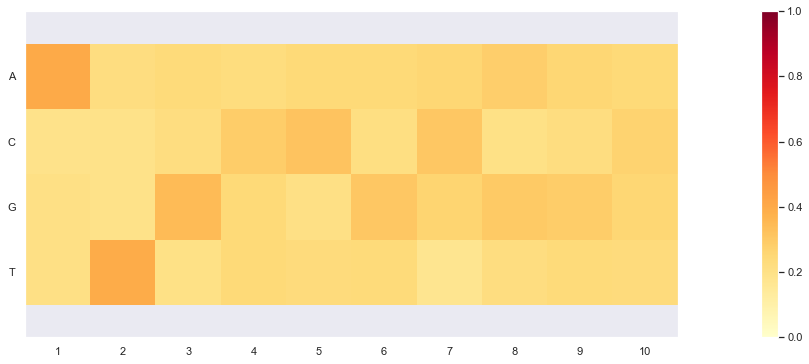

In [8]:
#Plot full heatmap
full_heatmap = make_heatmap(high_quality_trimmed)

ANALYSIS #3: Consensus Sequence

In [31]:
#Consensus Sequence
consensus_numerical = ''
for position in range(len(full_heatmap)):
    consensus_numerical+=(str(full_heatmap[position].index(max(full_heatmap[position]))))

# translation table - a dictionary

mytable = consensus_numerical.maketrans("0", "A")
consensus_numerical=consensus_numerical.translate(mytable)
mytable = consensus_numerical.maketrans("1", "C")
consensus_numerical=consensus_numerical.translate(mytable)
mytable = consensus_numerical.maketrans("2", "G")
consensus_numerical=consensus_numerical.translate(mytable)
mytable = consensus_numerical.maketrans("3", "U")
consensus_numerical=consensus_numerical.translate(mytable)

print('Consensus Sequence: '+ consensus_numerical)

Consensus Sequence: AUGCCGCGGC


ANALYSIS #4: Another visualization of nucleotide breakdown by position

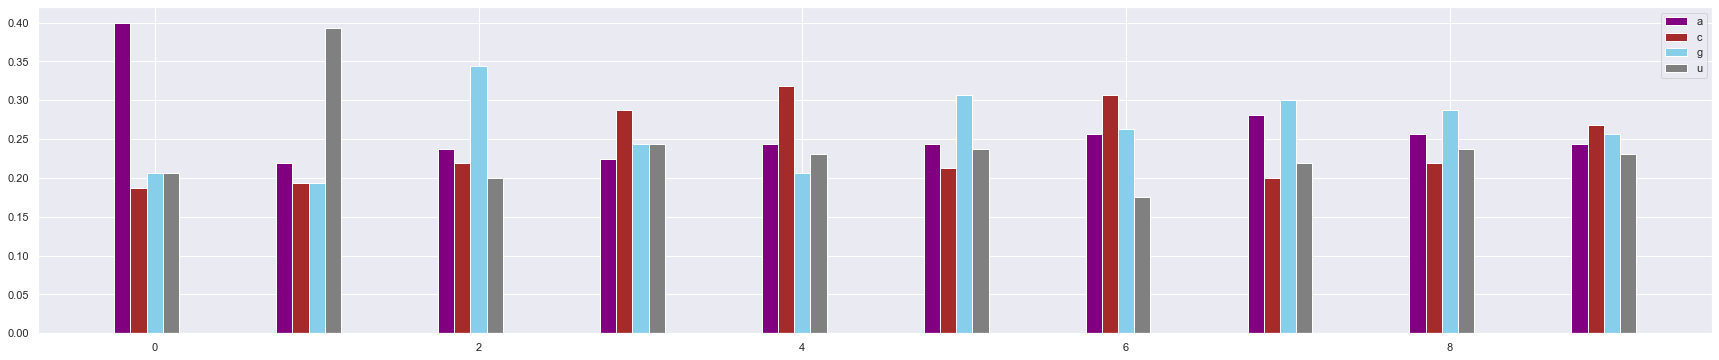

In [10]:
#Bar plot by position
fig, ax = plt.subplots(figsize = (30,6));
x = np.arange(1,len(full_heatmap)+1)
a = []
c = []
g = []
u = []
for position in full_heatmap:
    a.append(position[0])
    c.append(position[1])
    g.append(position[2])
    u.append(position[3])
    
width = 0.10
# plot data in grouped manner of bar type
for x in range(len(a)):
    plt.bar(x-0.2, a[x], width, color = 'purple', label = 'a')
    plt.bar(x-0.1, c[x], width, color = 'brown', label = 'c')
    plt.bar(x, g[x], width, color = 'skyblue', label = 'g')
    plt.bar(x+0.1, u[x], width, color = 'gray', label = 'u')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

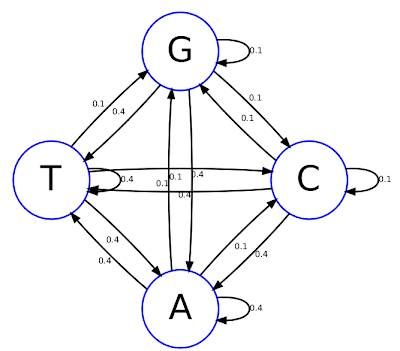

ANALYSIS #5: Make a HMM transition matrix for the 3 nucleotides in the predicted codon

In [11]:
#HMM - ID a triplet and make a transition matrix

def transition_matrix(position1, position2, scaled):
    connections = [ [ 0 for i in range(4) ] for j in range(4) ]

    for letter in ['A','C','G','U']:
        #If first nt = A, what are the transition probabilities
        second_nt = []
        for seq in high_quality_trimmed:
            if seq[position1] == letter:
                second_nt.append(seq[position2] )

        nt_dict = sorted(list(dict(collections.Counter(second_nt)).items()))
        counter= -1
        for element in nt_dict:
            counter+=1
            if scaled == 'True':
                if letter == 'A':
                    connections[0][counter] = element[1]/sum(list(dict(collections.Counter(second_nt)).values()))
                if letter == 'C':
                    connections[1][counter] = element[1]/sum(list(dict(collections.Counter(second_nt)).values()))
                if letter == 'G':
                    connections[2][counter] = element[1]/sum(list(dict(collections.Counter(second_nt)).values()))
                if letter == 'U':
                    connections[3][counter] = element[1]/sum(list(dict(collections.Counter(second_nt)).values()))
            if scaled == 'False':
                if letter == 'A':
                    connections[0][counter] = element[1]
                if letter == 'C':
                    connections[1][counter] = element[1]
                if letter == 'G':
                    connections[2][counter] = element[1]
                if letter == 'U':
                    connections[3][counter] = element[1]

    yticklabels = ['A','C','G','U']
    xticklabels = yticklabels

    fig = plt.figure(num=1, figsize=(6, 6), facecolor='w', edgecolor='k')

    ax = sns.heatmap(np.array(connections), cbar=True, annot=True, annot_kws={"fontsize":15}, cmap="YlGnBu", yticklabels=yticklabels ,xticklabels=xticklabels)
    ax.set_ylabel('NT1', fontsize=18)
    ax.set_xlabel('NT2', fontsize=18)


NT1 - NT2


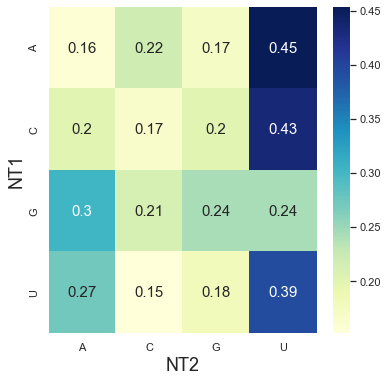

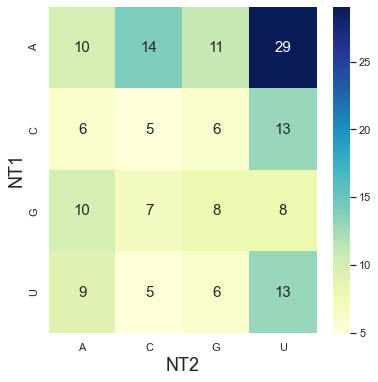

NT2 - NT3


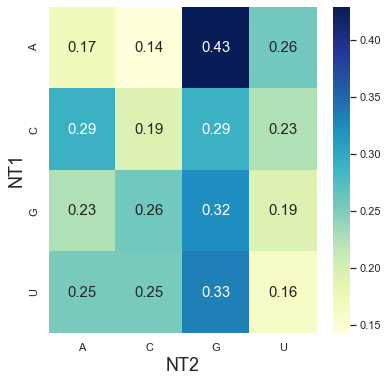

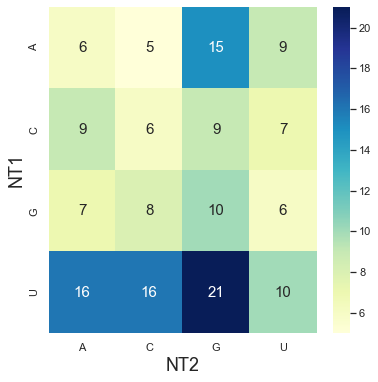

NT1 - NT3


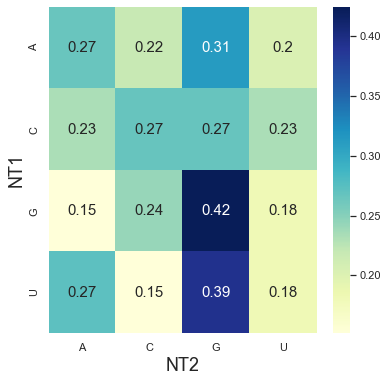

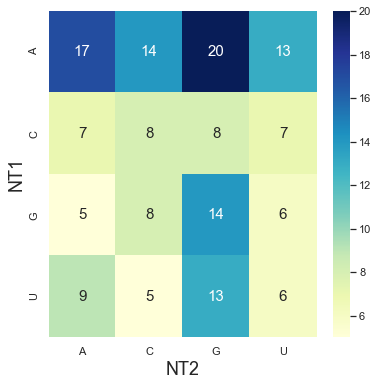

(<module 'matplotlib.pyplot' from '/Users/zoeweiss/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 None)

In [12]:
#Transition matrix from NT1-2
print('NT1 - NT2')
transition_matrix(triplet_start-1, triplet_start, 'True')
plt.show()
transition_matrix(triplet_start-1, triplet_start, 'False')
plt,show()
#Transition matrix from NT2-3
print('NT2 - NT3')
transition_matrix(triplet_start, triplet_start+1, 'True')
plt.show()
transition_matrix(triplet_start, triplet_start+1, 'False')
plt,show()
#Transition matrix from NT1-3
print('NT1 - NT3')
transition_matrix(triplet_start-1, triplet_start+1, 'True')
plt.show()
transition_matrix(triplet_start-1, triplet_start+1, 'False')
plt,show()